45.0
45.0
[0.24020689 0.58381622 0.2        0.65407633 0.23822638 0.7
 0.30107009 0.56733892 0.20128765 0.2        0.58152488 0.2
 0.2        0.31991659 0.45650242 0.2        0.7        0.7
 0.52264501 0.2        0.5649034  0.2        0.7        0.7
 0.2        0.48530799 0.2        0.7        0.2        0.6501181
 0.60102735 0.42615146 0.2        0.7        0.42629423 0.68562057
 0.2599866  0.64814557 0.7        0.33579713 0.62777386 0.2
 0.7        0.7        0.3270889  0.5388923  0.33391344 0.2
 0.32672747 0.2        0.2        0.2        0.52930369 0.62244194
 0.49093179 0.32065883 0.2        0.7        0.6525961  0.58022175
 0.46584883 0.62811154 0.58891872 0.39881863 0.50249156 0.25843904
 0.2        0.26401411 0.27643288 0.28651262 0.64653135 0.2285516
 0.28805102 0.29211745 0.22901143 0.4732568  0.29057609 0.7
 0.53884588 0.2        0.7        0.21171437 0.7        0.7
 0.41253081 0.7        0.7        0.7        0.7        0.30674477
 0.41288353 0.7        0.7        0.7      

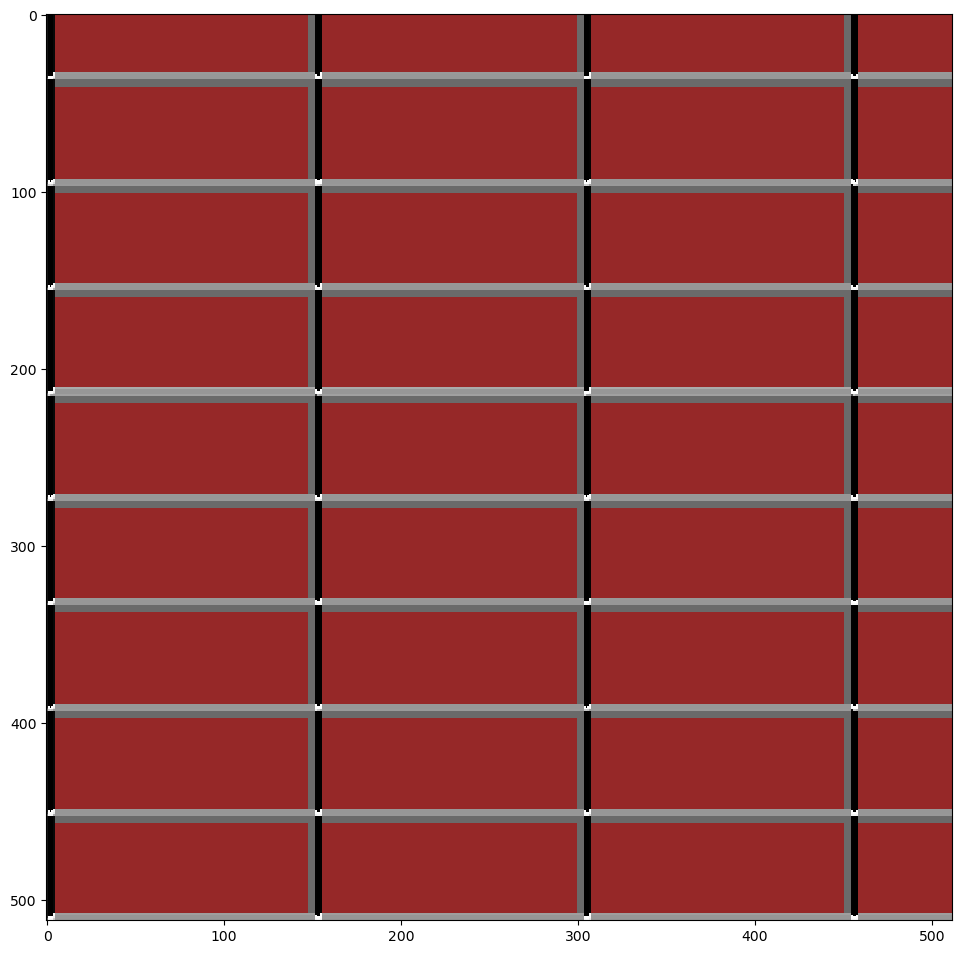

In [4]:
import numpy as np
import scipy as sp
import math

%matplotlib inline
from matplotlib import pyplot as plt

def step(a, x):
    return np.asfarray(a < x, dtype=float)

def stepf(a, x):
    return float(a < x)

a = np.random.rand(100)
b = step(0.5, a)
print(np.sum(b))

def pulse(a, b, x):
    return step(a, x) - step(b, x)

def pulsef(a, b, x):
    return stepf(a, x) - stepf(b, x)

c = pulse(0.2, 0.6, a)
print(np.sum(c))

def clamp(a, b, x):
    return np.fmin(np.fmax(a, x), b)

d = clamp(0.2, 0.7, a)
print(d)

def bias(b, x):
    return np.power(x, math.log(b) / math.log(0.5))

def gain(g, x):
    return np.where(x < 0.5, bias(1 - g, 2 * x) / 2, 1 - bias(1 - g, 2 - 2 * x) / 2)

def mix(x, y, a):
    return (1 - a) * x + a * y

def smoothstepf(a, b, x):
    if x < a:
        return 0
    if x >= b:
        return 1
    x = (x - a) / (b - a)
    return x * x * (3 - 2 * x)

def bump(a, b, u, v):
    
    ubump = smoothstepf(0, a, u) - smoothstepf(1 - a, 1, u)
    vbump = smoothstepf(0, b, v) - smoothstepf(1 - b, 1, v)
    return ubump * vbump

def brick(cbrick, cmortar, brick_w, brick_h, mortar_thickness, uoff, voff, u, v):
    light_dir = np.asarray([0, 1 / math.sqrt(2), 1 / math.sqrt(2)])
    bu = math.fmod(u - uoff, brick_w + mortar_thickness)
    bv = math.fmod(v - voff, brick_h + mortar_thickness)
    mstart = mortar_thickness * 0.5
    mendw = brick_w + mstart
    mendh = brick_h + mstart
    in_brick = pulsef(mstart, mendw, bu)
    in_brick *= pulsef(mstart, mendh, bv)
    
    up = np.asarray([0, 0, 1])
    uvec = np.asarray([1, 0, 0])
    vvec = np.asarray([0, 1, 0])
    buv = bump(mstart, mstart, bu, bv)
    bu1v = bump(mstart, mstart, bu + 0.0001, bv)
    buv1 = bump(mstart, mstart, bu, bv + 0.0001)
    buvec = np.asarray([0.0001, 0, bu1v - buv])
    buvec_len = np.linalg.norm(buvec)
    buvec /= buvec_len
    bvvec = np.asarray([0, 0.0001, buv1 - buv])
    bvvec_len = np.linalg.norm(bvvec)
    bvvec /= bvvec_len
    nn = np.cross(buvec, bvvec)
    cos_weight = np.dot(nn, light_dir)
    
    return mix(cmortar * cos_weight, cbrick, in_brick)

img_array = np.zeros((512, 512, 3), dtype=np.uint8)
for i in range(512):
    for j in range(512):
        u = j / 512.0
        v = (512 - i) / 512.0
        #img_array[i, j] = [v * 255, 0, 0]
        img_array[i, j] = brick(np.asarray([150, 40, 40]), np.asarray([150, 150, 150]), 0.28, 0.1, 0.016, 0, 0, u, v)
fig = plt.figure(figsize=(12, 12), dpi=100)
plt.imshow(img_array, interpolation='nearest')